## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import gensim.downloader as gensim_api 

from tqdm import tqdm 
tqdm.pandas()
import gc

In [2]:
train_dset_df = pd.read_csv("2020_10_19_train_dset_df_nostem_nostoprem.csv")
test_dset_df = pd.read_csv("2020_10_19_test_dset_df_nostem_nostoprem.csv")

train_dset_df["preprocessed_joined"].fillna("", inplace=True)
test_dset_df["preprocessed_joined"].fillna("", inplace=True)

train_dset_y = train_dset_df["target"].to_numpy()
word2vec = gensim_api.load("word2vec-google-news-300")

In [3]:
gc.collect()

0

## Trying stopword removal

Just tried it. Conclusion: Stopword Removal reduces performance by 0.08

In [163]:
# import nltk
# class Stopword_Remover:
#     def __init__(self):
#         self.stopwordCorpus = set(nltk.corpus.stopwords.words())
#     def stopword_removed(self, sentence_str):
#         return " ".join([word for word in sentence_str.split(" ") if not word in self.stopwordCorpus])

# stopword_remover = Stopword_Remover()
# train_dset_df["preprocessed_joined"] = train_dset_df["preprocessed_joined"].progress_apply(stopword_remover.stopword_removed)
# test_dset_df["preprocessed_joined"] = test_dset_df["preprocessed_joined"].progress_apply(stopword_remover.stopword_removed)

100%|██████████| 522449/522449 [00:01<00:00, 481450.08it/s]


# Part 1: Obtaining embeddings

## Embedder function

In [4]:
def embedding_entire_dset(dset_df_rows, embedding_vectors, num_embedding_columns, average=True):
    '''
    dset_df_rows: A pandas Series. Each entry is a string of space-separated words without numbers and special characters.
    embedding_vectors: A non-trainable embedding vectors instance from Gensim 
    num_embedding_columns: The number of columns.
    ''' 
    num_embedding_rows = len(dset_df_rows)
    embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    for row_index in tqdm(range(num_embedding_rows)):
        words = [word for word in dset_df_rows[row_index].split() if word in embedding_vectors]
        if(len(words) > 0):
            if(average):
                embedding_X[row_index,:] = np.mean(embedding_vectors[words], axis=0)
            else:
                embedding_X[row_index,:] = np.sum(embedding_vectors[words], axis=0)
    return embedding_X


## Averaged embeddings -- now testing sum embeddings

In [5]:
train_embedded_X = embedding_entire_dset(train_dset_df["preprocessed_joined"], word2vec, 300, average=False)

100%|██████████| 783673/783673 [00:36<00:00, 21754.37it/s]


In [6]:
test_embedded_X = embedding_entire_dset(test_dset_df["preprocessed_joined"], word2vec, 300, average=False)

100%|██████████| 522449/522449 [00:24<00:00, 21025.12it/s]


In [7]:
gc.collect()

0

## Metricsifier

In [8]:
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [9]:
def summarize(model, X, y):
    yhat = model.predict(X)
    print("F1 score:", f1_score(y, yhat))
    print("Precision:", precision_score(y, yhat))
    print("Recall:", recall_score(y, yhat))
    print("Confusion matrix:")
    plot_confusion_matrix(model, X, y)
    plt.show()

## LinearSVC

In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [14]:
svm = LinearSVC(penalty="l2",dual=True,class_weight={0:1,1:3.3}, C=0.01)

In [15]:
svm.fit(train_embedded_X, train_dset_y)

LinearSVC(C=0.01, class_weight={0: 1, 1: 3.3})

F1 score: 0.555840082579006
Precision: 0.5353817326628554
Recall: 0.5779240882541125
Confusion matrix:


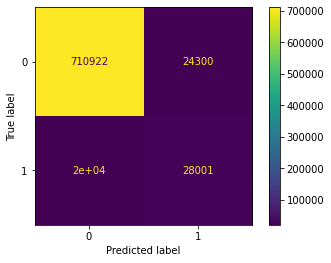

In [16]:
summarize(svm, train_embedded_X, train_dset_y)

## Cross-validation

In [17]:
from sklearn.model_selection import KFold



TRAINING:
F1 score: 0.4859291772397869
Precision: 0.483915765509391
Recall: 0.48795941323661074
Confusion matrix:


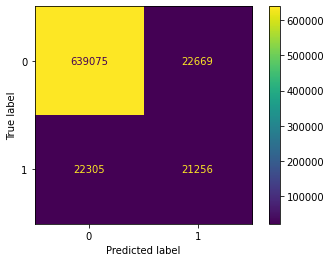


TESTING:
F1 score: 0.488834505965127
Precision: 0.48749237339841367
Recall: 0.4901840490797546
Confusion matrix:


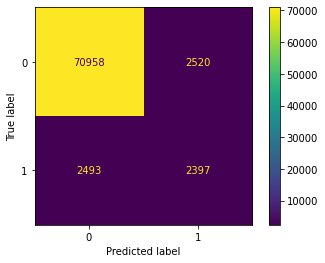



TRAINING:
F1 score: 0.48764954737751903
Precision: 0.4852654927345978
Recall: 0.49005714285714286
Confusion matrix:


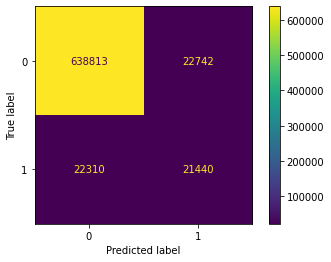


TESTING:
F1 score: 0.4803273528485993
Precision: 0.47391304347826085
Recall: 0.48691767708998085
Confusion matrix:


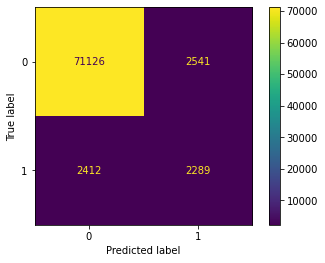



TRAINING:
F1 score: 0.4869894410362836
Precision: 0.4846792863952063
Recall: 0.4893217231897342
Confusion matrix:


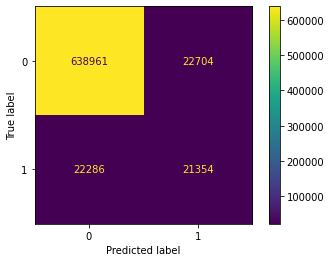


TESTING:
F1 score: 0.4823323374884104
Precision: 0.47814542483660133
Recall: 0.48659322386198295
Confusion matrix:


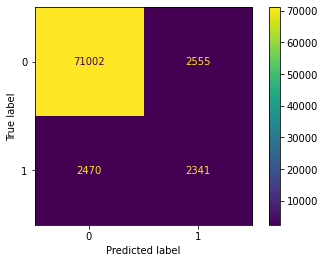



TRAINING:
F1 score: 0.4867431375905952
Precision: 0.48455857288944437
Recall: 0.48894748910800273
Confusion matrix:


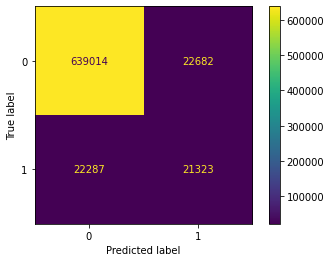


TESTING:
F1 score: 0.4819053510671203
Precision: 0.48106216550020586
Recall: 0.48275149762445774
Confusion matrix:


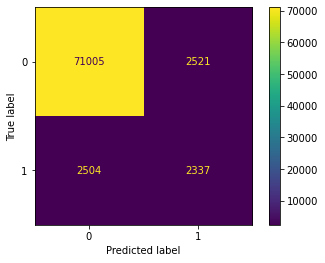



TRAINING:
F1 score: 0.4869076452040396
Precision: 0.48508991577509675
Recall: 0.4887390486674923
Confusion matrix:


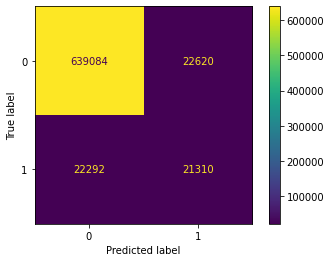


TESTING:
F1 score: 0.4876555804937768
Precision: 0.48253583686654555
Recall: 0.49288513095483605
Confusion matrix:


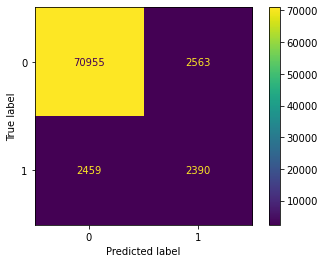



TRAINING:
F1 score: 0.48606680159628596
Precision: 0.48413475775039294
Recall: 0.4880143277002204
Confusion matrix:


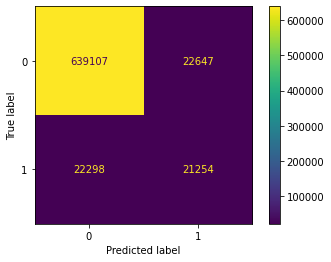


TESTING:
F1 score: 0.4897039237783014
Precision: 0.49156725627313863
Recall: 0.4878546642171872
Confusion matrix:


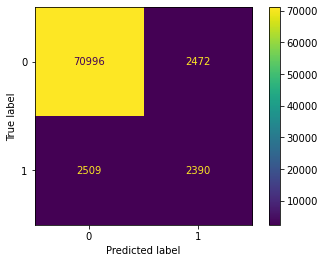



TRAINING:
F1 score: 0.4865433185147938
Precision: 0.48517378917378917
Recall: 0.487920601448611
Confusion matrix:


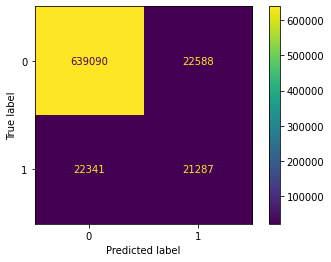


TESTING:
F1 score: 0.48014773776546626
Precision: 0.4752233956133225
Recall: 0.48517520215633425
Confusion matrix:


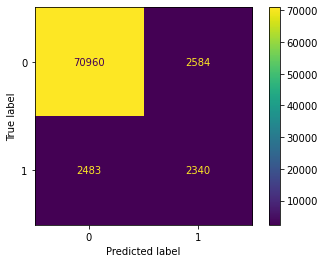



TRAINING:
F1 score: 0.4863359284034611
Precision: 0.48386144236229417
Recall: 0.4888358537760745
Confusion matrix:


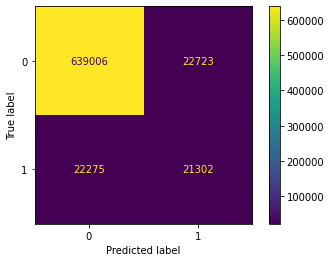


TESTING:
F1 score: 0.49170872386445563
Precision: 0.4936918304033092
Recall: 0.4897414854329093
Confusion matrix:


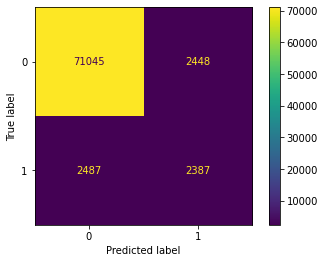



TRAINING:
F1 score: 0.48652043344713797
Precision: 0.4843469364556099
Recall: 0.4887135254175078
Confusion matrix:


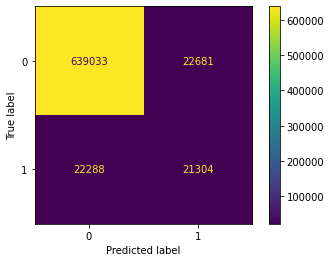


TESTING:
F1 score: 0.4866185000508802
Precision: 0.48128019323671495
Recall: 0.49207655896274954
Confusion matrix:


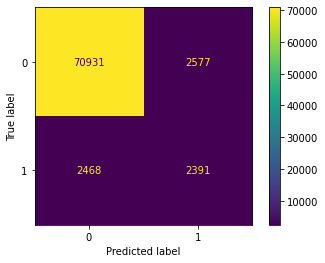



TRAINING:
F1 score: 0.48662869169354656
Precision: 0.4847877116616149
Recall: 0.4884837072588238
Confusion matrix:


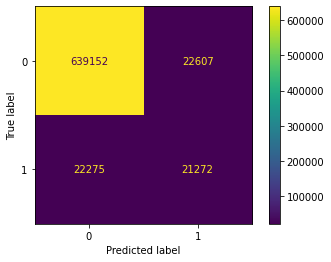


TESTING:
F1 score: 0.485122101374923
Precision: 0.4882280049566295
Recall: 0.4820554649265905
Confusion matrix:


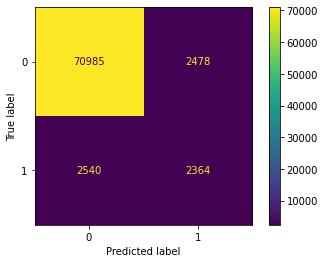

In [106]:
kfcv = KFold(n_splits=10, shuffle=True)
for train_indices, test_indices in kfcv.split(train_embedded_X):
    trainset_embedded_X = train_embedded_X[train_indices,:]
    trainset_y = train_dset_y[train_indices]
    testset_embedded_X = train_embedded_X[test_indices,:]
    testset_y = train_dset_y[test_indices]

    svm.fit(trainset_embedded_X, trainset_y)

    print("\n\nTRAINING:")
    summarize(svm, trainset_embedded_X, trainset_y)

    print("\nTESTING:")
    summarize(svm, testset_embedded_X, testset_y)


    

## Conclusion: Averaged embeddings with SVM saturate at F1 = 0.48

## Attempting Naive Bayes

In [169]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [179]:
gnb = GaussianNB(priors=(0.9999999999, 0.0000000001))

In [180]:
gnb.fit(train_embedded_X, train_dset_y)

GaussianNB(priors=(0.9999999999, 1e-10))

F1 score: 0.44996036362513253
Precision: 0.44889281459266256
Recall: 0.4510330024148108
Confusion matrix:


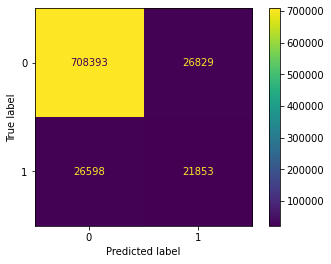

In [181]:
summarize(gnb, train_embedded_X, train_dset_y)

## Conclusion: Gaussian Naive Bayes on average embeddings saturates at training error 0.47

# Part 2: Concatenated embeddings

## Finding the cutoff for sentence length

In [154]:
train_dset_df["length"] = train_dset_df["preprocessed_joined"].progress_apply(lambda x: len(x.split(" ")))

100%|██████████| 783673/783673 [00:00<00:00, 910801.61it/s] 


In [155]:
import seaborn as sns

<AxesSubplot:xlabel='length', ylabel='Count'>

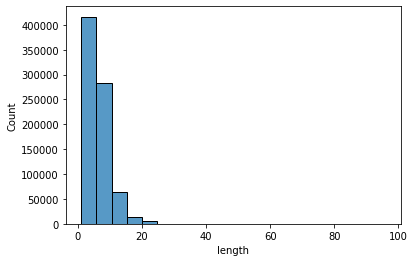

In [157]:
sns.histplot(train_dset_df["length"], bins=20)